In [33]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

from HMC import HMC
from flux_preprocessing import load_dataset

%matplotlib inline
plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13
data_dir = Path("../data")

In [34]:
EV1_train1, EV2_train1, NEE_train1, label_train, EV1_test1, EV2_test1, NEE_test, label_test = load_dataset(
    'NNinput_SCOPE_US_Ha1_1314.csv')

In [35]:
def NN_noSIF(n_neuron, activation1, activation2):
    # GPP
    APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
    EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
    x = Dense(n_neuron, activation=activation1, name='hidden1_1', use_bias=False)(EV_input1)
    #x         = Dense(n_neuron, activation=activation2,name='hidden1_2')(x)
    ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
    GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
    GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

    # Reco
    EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
    x = Dense(n_neuron, activation=activation1, name='hidden2_1', use_bias=False)(EV_input2)
    #, kernel_regularizer=tf.keras.regularizers.l2(0.0000)
    #x         = Dense(n_neuron, activation=activation2,name='hidden2_2')(x)
    ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
    Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

    NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

    model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
    model_NEE.compile(
        optimizer=keras.optimizers.Adam(5e-3),
        loss=keras.losses.MeanSquaredError()
    )

    return model_NEE

In [36]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
model_noSIF = NN_noSIF(n_neuron=1, activation1='relu', activation2='relu')
hist_noSIF = model_noSIF.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=1000,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=1)

Epoch 1/1000
51/51 [==============================] - 0s 3ms/step - loss: 4.4836 - val_loss: 1.5382
Epoch 2/1000
51/51 [==============================] - 0s 2ms/step - loss: 1.2300 - val_loss: 0.8050
Epoch 3/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.7536 - val_loss: 0.5683
Epoch 4/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.5462 - val_loss: 0.4367
Epoch 5/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.4229 - val_loss: 0.3524
Epoch 6/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.3432 - val_loss: 0.2966
Epoch 7/1000
51/51 [==============================] - 0s 3ms/step - loss: 0.2887 - val_loss: 0.2518
Epoch 8/1000
51/51 [==============================] - 0s 4ms/step - loss: 0.2478 - val_loss: 0.2181
Epoch 9/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.2163 - val_loss: 0.1924
Epoch 10/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.1910 - val_loss: 0.1726

In [37]:
model_noSIF.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EV_input1 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 EV_input2 (InputLayer)         [(None, 4)]          0           []                               
                                                                                                  
 hidden1_1 (Dense)              (None, 1)            6           ['EV_input1[0][0]']              
                                                                                                  
 hidden2_1 (Dense)              (None, 1)            4           ['EV_input2[0][0]']              
                                                                                            

In [38]:
burn_in = 2000
n_iter = 4000
n_obs = NEE_train1.shape[0]


def sample(model, inputs):
    # Create HMC super-model
    n_obs = inputs[1].shape[0]
    hmc = HMC(model, L=20, epsilon_min=3e-4, epsilon_max=3e-4, batch_size=n_obs, n_obs=n_obs)

    # Initialize bookkeeping
    parameters = []  # bookkeeping the parameters
    log_gamma = []  # bookkeeping the loggamma
    log_lambda = []  # bookkeeping the loggamma
    log_likelihood = []  # bookkeeping the loggamma
    hamiltonians = []
    acceptance = []

    # training loop
    hmc.init_parameters(inputs)
    for step in tqdm(range(n_iter + burn_in)):
        new_state, loss, p, accepted, h = hmc(inputs, tf.constant(step, dtype=tf.float32),
                                              tf.constant(n_iter, dtype=tf.float32))

        # bookkeeping
        if step > burn_in:
            parameters.append(new_state.position)
            log_gamma.append(new_state.log_gamma)
            log_lambda.append(new_state.log_lambda)
            log_likelihood.append(loss)
            acceptance.append(accepted)
            hamiltonians.append(h)

    parameters = tf.stack(parameters, axis=0).numpy()
    log_gamma = tf.concat(log_gamma, axis=0).numpy()
    log_lambda = tf.concat(log_lambda, axis=0).numpy()
    log_likelihood = tf.concat(log_likelihood, axis=0).numpy()
    hamiltonians = tf.concat(hamiltonians, axis=0).numpy()
    acceptance = np.array(acceptance)
    print(f"Sampling done: {n_iter} steps with accepting rate {np.mean(acceptance)}")
    return hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance

In [39]:
hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance = sample(model_noSIF, (
{'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))

100%|██████████| 6000/6000 [01:18<00:00, 75.97it/s]


Sampling done: 4000 steps with accepting rate 0.6936734183545886


In [40]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = parameters[idx_MAP, :]
hmc.set_model_params(MAP)
y_MAP = hmc.model({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})

# preparing sampling
precision = np.exp(log_gamma)
num_dim = 1
n_samples = 200
trajectories = np.zeros((n_obs, num_dim, n_samples))
sigma_normal = np.std(NEE_train1)

# sampling
for k in tqdm(range(n_samples)):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2] * num_dim
    hmc.set_model_params(w_sample)
    trajectories[:, :, k] = hmc.model({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})\
                            + sigma_normal * np.random.normal() / np.sqrt(precision_here)

mu_pred = np.mean(trajectories, axis=2)
sigma_pred = np.var(trajectories, axis=2)

100%|██████████| 200/200 [00:00<00:00, 266.29it/s]


IndexError: index 14 is out of bounds for axis 1 with size 14

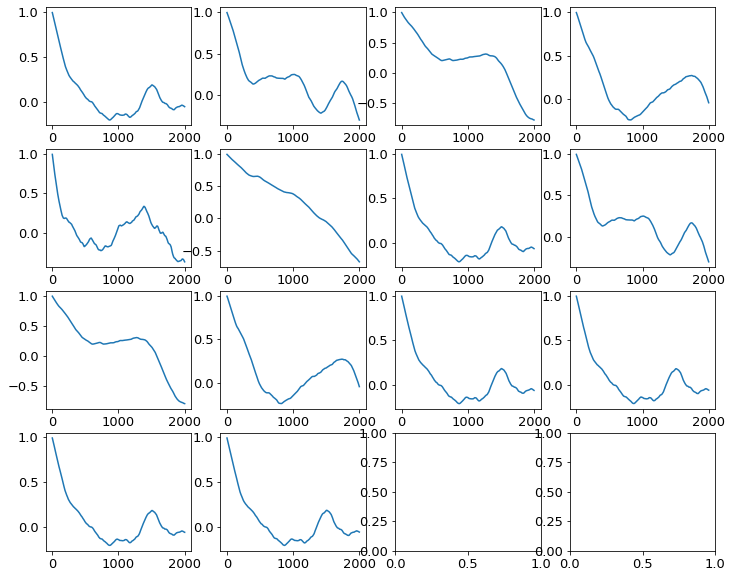

In [41]:
# plot auto-correlation

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
axs = axs.flatten()
max_lag = 2000
for i in range(len(axs)):
    auto_cor = []
    mean = np.mean(parameters[:, i])
    var = np.var(parameters[:, i])
    for lag in range(1, max_lag):
        param = parameters[lag:, i]
        param_lagged = parameters[:-lag, i]
        auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
    axs[i].plot(np.arange(1, max_lag), auto_cor)
plt.tight_layout()
plt.show()

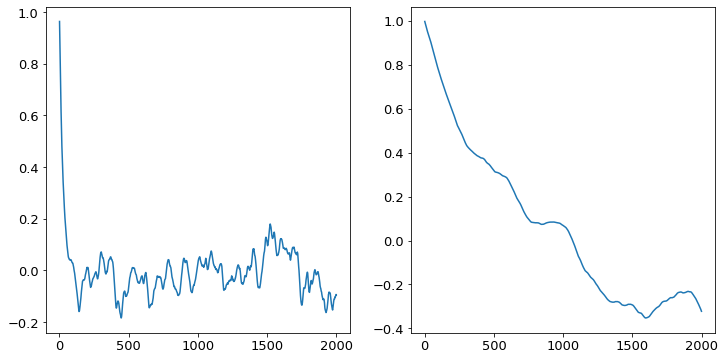

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

mean = np.mean(log_gamma)
var = np.var(log_gamma)
auto_cor = []
for lag in range(1, max_lag):
    param = log_gamma[lag:]
    param_lagged = log_gamma[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[0].plot(np.arange(1, max_lag), auto_cor)

mean = np.mean(log_lambda)
var = np.var(log_lambda)
auto_cor = []
for lag in range(1, max_lag):
    param = log_lambda[lag:]
    param_lagged = log_lambda[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[1].plot(np.arange(1, max_lag), auto_cor)
plt.show()

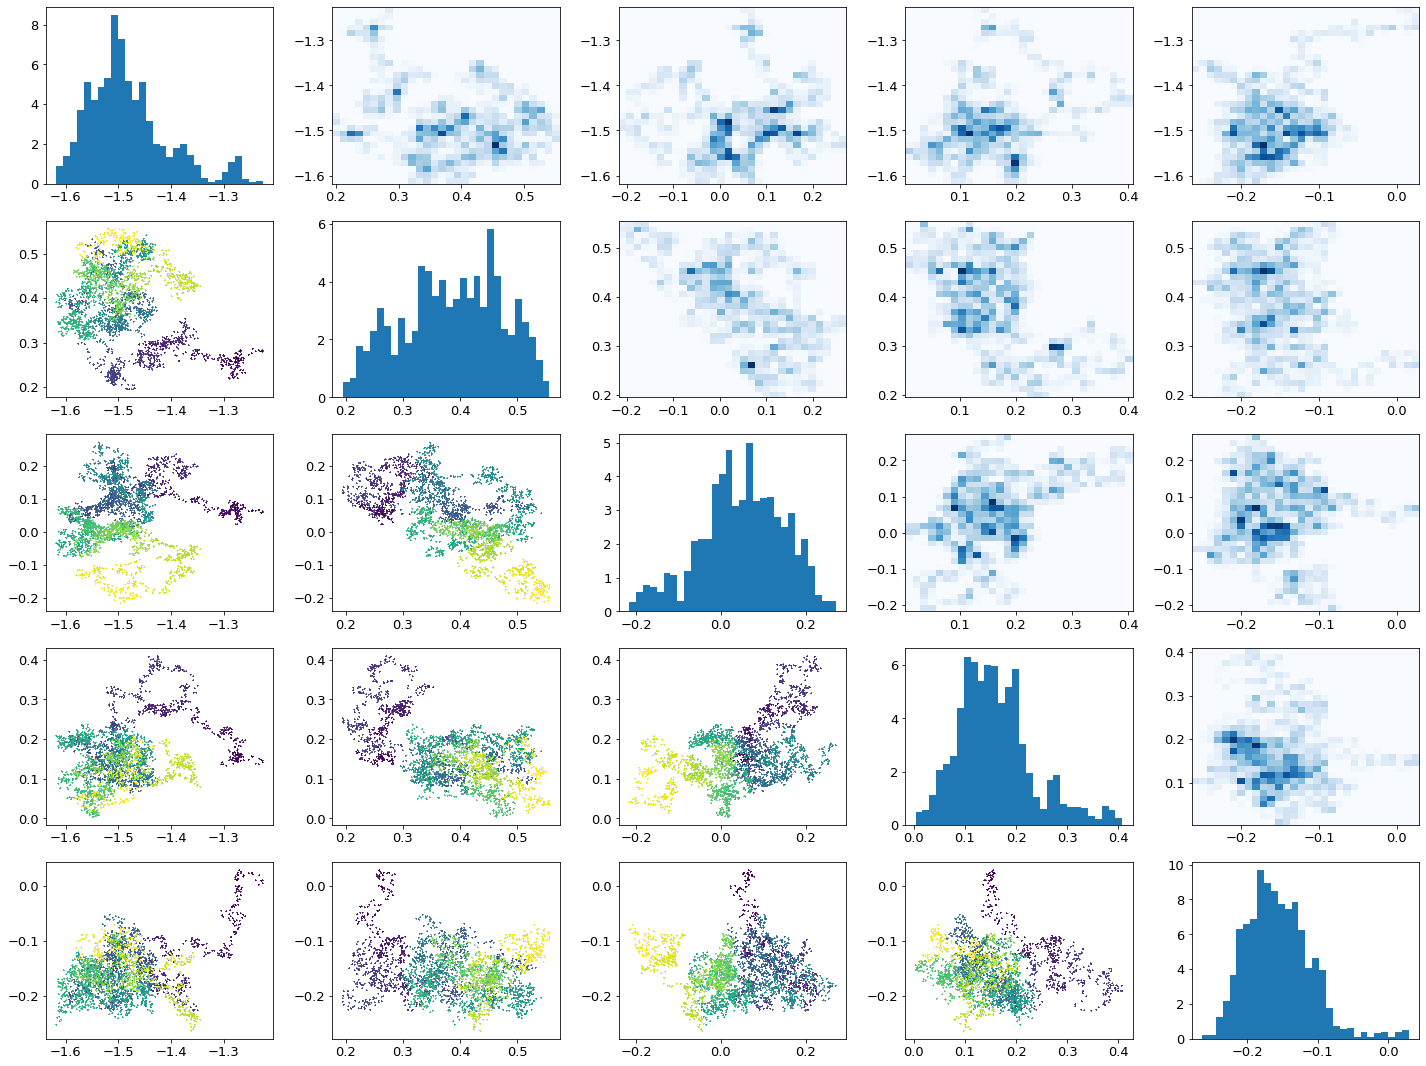

In [43]:
# plot parameters spread
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(axs.shape[0]):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+", c=np.arange(parameters.shape[0]))
    for j in range(i + 1, axs.shape[0]):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.tight_layout()
plt.show()